<a href="https://colab.research.google.com/github/hansglick/book_errata/blob/main/p017_BERT_Pretreatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 8.4 MB/s 


In [3]:
import tensorflow_text as text
import functools
import tensorflow as tf
print(tf.__version__)

2.8.2


# Objectif
L'objectif du notebook est le pretraitement de texte brute afin qu'il puisse servir d'inputsà des réseaux de neurones, plus particulièrement les prétraitement utilisés pour l'apprentissage du modèle de BERT

# Data

In [4]:
examples = {
    "text_a": [
      "Sponge bob Squarepants is an Avenger",
      "Marvel Avengers"
    ],
    "text_b": [
     "Barack Obama is the President.",
     "President is the highest office"
  ],
}

dataset = tf.data.Dataset.from_tensor_slices(examples)

 * Le **BERT Tokenizer** :
   * Il faut construire une LookUpTable via `tf.lookup.StaticVocabularyTable`
   * La LookUpTable prend en entrée un key initializer qu'on construit via `tf.lookup.KeyValueTensorInitializer`
   * Ce KeyValue prend en entrée le VOCABULAIRE à savoir une liste de strings.
     * Ce vocabulaire peut contenir, des specials tokens comme CLS, SEP, MASK, RANDOM, UNK
     * Ce vocabulaire peut contenir les suffixes
     * Ce vocabulaire contient également évidemment les mots
  * Création du tokenize : `bert_tokenizer = text.BertTokenizer(lookup_table, token_out_type=tf.string)` . On peut également choisir `token_out=tf.int64`
  * L'application du tokenizer produit un Ragged Tensor

In [5]:
# Définition du vocabulaire
_VOCAB = [
    b"[UNK]", b"[MASK]", b"[RANDOM]", b"[CLS]", b"[SEP]",
    b"##ack", b"##ama", b"##ger", b"##gers", b"##onge", b"##pants",  b"##uare",
    b"##vel", b"##ven", b"an", b"A", b"Bar", b"Hates", b"Mar", b"Ob",
    b"Patrick", b"President", b"Sp", b"Sq", b"bob", b"box", b"has", b"highest",
    b"is", b"office", b"the",
]

# KeyValue object
kv_obj = tf.lookup.KeyValueTensorInitializer(
      keys=_VOCAB,
      key_dtype=tf.string,
      values=tf.range(
          tf.size(_VOCAB, out_type=tf.int64), dtype=tf.int64),
          value_dtype=tf.int64
        )

# Création du lookup_table
lookup_table = tf.lookup.StaticVocabularyTable(kv_obj,num_oov_buckets=1)

# Création du Tokenizer
#bert_tokenizer = text.BertTokenizer(lookup_table, token_out_type=tf.string)

# Création du Tokenizer
bert_tokenizer = text.BertTokenizer(lookup_table, token_out_type=tf.int64)

# Application du Tokenizer
a = bert_tokenizer.tokenize(examples["text_a"])
b = bert_tokenizer.tokenize(examples["text_b"])

print(a)
print('')
print(b)
print('')

# Réduction de la dimension 'token'
a = a.merge_dims(-2, -1)
b = b.merge_dims(-2, -1)
print(a)
print('')
print(b)

<tf.RaggedTensor [[[22, 9], [24], [23, 11, 10], [28], [14], [15, 13, 7]],
 [[18, 12], [15, 13, 8]]]>

<tf.RaggedTensor [[[16, 5], [19, 6], [28], [30], [21], [0]], [[21], [28], [30], [27], [29]]]>

<tf.RaggedTensor [[22, 9, 24, 23, 11, 10, 28, 14, 15, 13, 7], [18, 12, 15, 13, 8]]>

<tf.RaggedTensor [[16, 5, 19, 6, 28, 30, 21, 0], [21, 28, 30, 27, 29]]>


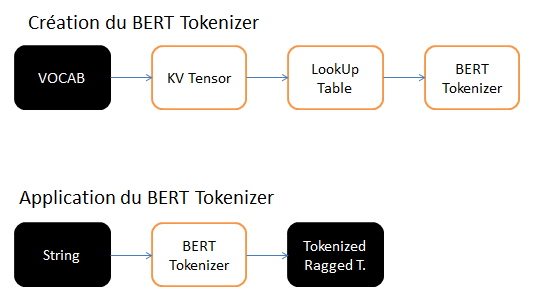



# Parameters

In [6]:
# Parameters (useless pour le tokenizer)
_START_TOKEN = _VOCAB.index(b"[CLS]")
_END_TOKEN = _VOCAB.index(b"[SEP]")
_MASK_TOKEN = _VOCAB.index(b"[MASK]")
_RANDOM_TOKEN = _VOCAB.index(b"[RANDOM]")
_UNK_TOKEN = _VOCAB.index(b"[UNK]")
_MAX_SEQ_LEN = 8
_MAX_PREDICTIONS_PER_BATCH = 5
_VOCAB_SIZE = len(_VOCAB)

 * Le **content trimming** :
   * Les modèles comme BERT prennent des paires de phrases comme observations. Cependant, les phrases ne peuvent dépasser une certaine taille par exemple. Il faut donc tronquer ces phrases que ce soit à droite ou à gauche.
   * `text.RoundRobinTrimmer(max_seq_length=_MAX_SEQ_LEN)` permet d'instancier un objet trimmer
   * `obj.trm(string)` permet de trimer les sentences à savoir les tronquer à droite


In [7]:
print(a)
print(b)
print('')
trimmer = text.RoundRobinTrimmer(max_seq_length=_MAX_SEQ_LEN)
trimmed = trimmer.trim([a, b])
print(trimmed)
print('')

<tf.RaggedTensor [[22, 9, 24, 23, 11, 10, 28, 14, 15, 13, 7], [18, 12, 15, 13, 8]]>
<tf.RaggedTensor [[16, 5, 19, 6, 28, 30, 21, 0], [21, 28, 30, 27, 29]]>

[<tf.RaggedTensor [[22, 9, 24, 23],
 [18, 12, 15, 13]]>, <tf.RaggedTensor [[16, 5, 19, 6],
 [21, 28, 30, 27]]>]



 * Le **combining segment** :    
   * En pratique la paire de sentences qui sert d'input est mergé et accompagné d'un vecteur informatif qui représente la première et la seconde phrase
   * `text.combine_segments(trimmed,start_of_sequence_id=_START_TOKEN, end_of_segment_id=_END_TOKEN)` permet de faire cette combinaison
   * La fonction renvoie le merging et le vecteur informatif
   * La fonction ajoute également des END token, START token


In [8]:
segments_combined, segments_ids = text.combine_segments(trimmed,
                                                        start_of_sequence_id=_START_TOKEN,
                                                        end_of_segment_id=_END_TOKEN)

print(segments_combined)
print(segments_ids)

<tf.RaggedTensor [[3, 22, 9, 24, 23, 4, 16, 5, 19, 6, 4],
 [3, 18, 12, 15, 13, 4, 21, 28, 30, 27, 4]]>
<tf.RaggedTensor [[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]>


 * **Sélection de Tokens** :    
   * Dans les language models, on sélectionne des tokens qu'on va essayer de prédire via le model, c'est la raison pour laquelle un objet est nécessaire
   * Création d'un objet RandomItemSelect via `text.RandomItemSelector()`
     * `max_selections_per_batch` : le nombre max de tokens choisis ds un batch
     * `selection_rate` : float entre 0 et 1 qui représente la fréquence à laquelle on sélectionne un item
     * `unselectable_ids` : une liste d'entiers qui représente les token ids interdits comme ceux représentant START, END et UNK 
  * La méthode `.get_selection_mask()` d'un objet instancié RandomItemSelector renverra un batch de booléen où True indique la sélection de l'item

In [9]:
# Instanciation d'un objet randomitemselector
random_selector = text.RandomItemSelector(
    max_selections_per_batch=_MAX_PREDICTIONS_PER_BATCH,
    selection_rate=0.2,
    unselectable_ids=[_START_TOKEN, _END_TOKEN, _UNK_TOKEN]
)

# Sélection des item de segments_combined
selected = random_selector.get_selection_mask(
    segments_combined, axis=1)

print(selected)

<tf.RaggedTensor [[False, True, False, False, False, False, False, True, False, False,
  False],
 [False, False, True, False, True, False, False, False, False, False,
  False]]>


 * le **Mask Values Chooser** :
   * Il faut pouvoir choisir des tokens aléatoirement et les remplacer parfois par un autre token parfois la laisser tel quel
   * Pour ce faire, on peut instancier un `text.MaskValuesChooser` object
   * Puis l'appliquer sur un ragged tensor ou un tensor classique via la méthode `.get_mask_values()`
   * J'ai dû mal à suivre pour l'instant le processus qu'on doit suivre ni comment doit s'emboîter le randomitemselector et le maskvalueschooser

In [10]:
mask_values_chooser = text.MaskValuesChooser(_VOCAB_SIZE, _MASK_TOKEN, 0.8)
ex = mask_values_chooser.get_mask_values(segments_combined)
print(_MASK_TOKEN)
print(ex)

1
<tf.RaggedTensor [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 25, 1, 1, 1]]>


 * La fonction **mask_language_model** :
   * Elle permet de combiner le `maskvaluechooser` et le `randomitemselector`
   * Sélection aléatoire de tokens à masquer
   * Ces masked tokens sont alors ou bien
     * Modifiés en autre token (afin de s'assurer que le modèle peut comprendre globalement le sens d'une phrase même si certains mots font difficilement sens)
     * Modifiés en < MASK > token
     * Laissés inchangés
   * Elle produit trois outputs :    
     * `masked_input_ids` : c'est l'input modifié, i.e. l'input de départ avec les tokens modifiés ou pas (no change, mask token, modified token)    
     * `masked_positions` : c'est la position des tokens qui ont été modifiés, i.e. ou bien des mask tokens ou bien des mots nouveaux
     * `masked_ids` : c'est le valeur des tokens ids d'origine
  * `tf.gather(_VOCAB, masked_token_ids)` : permet de décoder la phrase tokenisés
 

In [11]:
masked_token_ids, masked_pos, masked_lm_ids = text.mask_language_model(
  segments_combined,
  item_selector=random_selector, mask_values_chooser=mask_values_chooser)

decoded_sentence = tf.gather(_VOCAB, masked_token_ids)

print(segments_combined)
print('')
print(masked_token_ids)
print('')
print(masked_pos)
print('')
print(masked_lm_ids)
print('')
print(decoded_sentence)

<tf.RaggedTensor [[3, 22, 9, 24, 23, 4, 16, 5, 19, 6, 4],
 [3, 18, 12, 15, 13, 4, 21, 28, 30, 27, 4]]>

<tf.RaggedTensor [[3, 22, 1, 24, 23, 4, 16, 1, 19, 6, 4],
 [3, 18, 1, 15, 13, 4, 21, 28, 30, 27, 4]]>

<tf.RaggedTensor [[2, 7],
 [2, 4]]>

<tf.RaggedTensor [[9, 5],
 [12, 13]]>

<tf.RaggedTensor [[b'[CLS]', b'Sp', b'[MASK]', b'bob', b'Sq', b'[SEP]', b'Bar', b'[MASK]',
  b'Ob', b'##ama', b'[SEP]'],
 [b'[CLS]', b'Mar', b'[MASK]', b'A', b'##ven', b'[SEP]', b'President',
  b'is', b'the', b'highest', b'[SEP]']]>


 * le **padding** :
   * Avec `text.pad_model_inputs()` permet de padder et de créer le mask correspondant à un tensor de tokens
   * Il prend deux arguments, un `ragged tensor` et une `max_len` pour le padding
   * Il produit un tuple de deux outputs `input_word_ids` et `input_mask` qui correspondent au tensor final et à son masque
   * En pratique, on répète l'opération pour l'input original et le segment ids

In [12]:
# Prepare and pad combined segment inputs
input_word_ids, input_mask = text.pad_model_inputs(
  masked_token_ids, max_seq_length=_MAX_SEQ_LEN)
input_type_ids, _ = text.pad_model_inputs(
  segments_ids, max_seq_length=_MAX_SEQ_LEN)

# Prepare and pad masking task inputs
masked_lm_positions, masked_lm_weights = text.pad_model_inputs(
  masked_pos, max_seq_length=_MAX_PREDICTIONS_PER_BATCH)
masked_lm_ids, _ = text.pad_model_inputs(
  masked_lm_ids, max_seq_length=_MAX_PREDICTIONS_PER_BATCH)

model_inputs = {
    "input_word_ids": input_word_ids, # le tensor d'entrée avec les modifs
    "input_mask": input_mask, # le mask du padding 1 veut dire que c'est pas rembourrage
    "input_type_ids": input_type_ids, # le vecteur informatif qui représente la phrase 1 et la phrase 2
    "masked_lm_ids": masked_lm_ids, # les tokens id à prédire
    "masked_lm_positions": masked_lm_positions, # les places des tokens a prevoir
    "masked_lm_weights": masked_lm_weights, # les masks des tokens à prédire 1 signifie token à prédire, 0 sinon
}
model_inputs

{'input_mask': <tf.Tensor: shape=(2, 8), dtype=int64, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])>,
 'input_type_ids': <tf.Tensor: shape=(2, 8), dtype=int64, numpy=
 array([[0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1]])>,
 'input_word_ids': <tf.Tensor: shape=(2, 8), dtype=int64, numpy=
 array([[ 3, 22,  1, 24, 23,  4, 16,  1],
        [ 3, 18,  1, 15, 13,  4, 21, 28]])>,
 'masked_lm_ids': <tf.Tensor: shape=(2, 5), dtype=int64, numpy=
 array([[ 9,  5,  0,  0,  0],
        [12, 13,  0,  0,  0]])>,
 'masked_lm_positions': <tf.Tensor: shape=(2, 5), dtype=int64, numpy=
 array([[2, 7, 0, 0, 0],
        [2, 4, 0, 0, 0]])>,
 'masked_lm_weights': <tf.Tensor: shape=(2, 5), dtype=int64, numpy=
 array([[1, 1, 0, 0, 0],
        [1, 1, 0, 0, 0]])>}

In [13]:
def bert_pretrain_preprocess(vocab_table, features):
  # Input is a string Tensor of documents, shape [batch, 1].
  text_a = features["text_a"]
  text_b = features["text_b"]

  # Tokenize segments to shape [num_sentences, (num_words)] each.
  tokenizer = text.BertTokenizer(
      vocab_table,
      token_out_type=tf.int64)
  segments = [tokenizer.tokenize(text).merge_dims(
      1, -1) for text in (text_a, text_b)]

  # Truncate inputs to a maximum length.
  trimmer = text.RoundRobinTrimmer(max_seq_length=6)
  trimmed_segments = trimmer.trim(segments)

  # Combine segments, get segment ids and add special tokens.
  segments_combined, segment_ids = text.combine_segments(
      trimmed_segments,
      start_of_sequence_id=_START_TOKEN,
      end_of_segment_id=_END_TOKEN)

  # Apply dynamic masking task.
  masked_input_ids, masked_lm_positions, masked_lm_ids = (
      text.mask_language_model(
        segments_combined,
        random_selector,
        mask_values_chooser,
      )
  )

  # Prepare and pad combined segment inputs
  input_word_ids, input_mask = text.pad_model_inputs(
    masked_input_ids, max_seq_length=_MAX_SEQ_LEN)
  input_type_ids, _ = text.pad_model_inputs(
    segment_ids, max_seq_length=_MAX_SEQ_LEN)

  # Prepare and pad masking task inputs
  masked_lm_positions, masked_lm_weights = text.pad_model_inputs(
    masked_lm_positions, max_seq_length=_MAX_PREDICTIONS_PER_BATCH)
  masked_lm_ids, _ = text.pad_model_inputs(
    masked_lm_ids, max_seq_length=_MAX_PREDICTIONS_PER_BATCH)

  model_inputs = {
      "input_word_ids": input_word_ids,
      "input_mask": input_mask,
      "input_type_ids": input_type_ids,
      "masked_lm_ids": masked_lm_ids,
      "masked_lm_positions": masked_lm_positions,
      "masked_lm_weights": masked_lm_weights,
  }
  return model_inputs

In [14]:
dataset = tf.data.Dataset.from_tensors(examples)
dataset = dataset.map(functools.partial(
    bert_pretrain_preprocess, lookup_table))

next(iter(dataset))

{'input_mask': <tf.Tensor: shape=(2, 8), dtype=int64, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])>,
 'input_type_ids': <tf.Tensor: shape=(2, 8), dtype=int64, numpy=
 array([[0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1]])>,
 'input_word_ids': <tf.Tensor: shape=(2, 8), dtype=int64, numpy=
 array([[ 3,  1,  9, 24,  4,  1,  5, 19],
        [ 3, 18,  1, 15,  4, 21, 28,  0]])>,
 'masked_lm_ids': <tf.Tensor: shape=(2, 5), dtype=int64, numpy=
 array([[22, 16,  0,  0,  0],
        [12, 30,  0,  0,  0]])>,
 'masked_lm_positions': <tf.Tensor: shape=(2, 5), dtype=int64, numpy=
 array([[1, 5, 0, 0, 0],
        [2, 7, 0, 0, 0]])>,
 'masked_lm_weights': <tf.Tensor: shape=(2, 5), dtype=int64, numpy=
 array([[1, 1, 0, 0, 0],
        [1, 1, 0, 0, 0]])>}

In [ ]:
# A savoir
# On peut merge un ragged tensor avec la méthode .merge_dims()
